# 🔬 BiomedCLIP Fine-tuning for Ocular Toxoplasmosis

This notebook fine-tunes Microsoft's BiomedCLIP model to classify retinal images for toxoplasmosis.
## 📋 Steps:
1. Setup environment
2. Download dataset from Zenodo
3. Download pipeline code
4. Prepare data
5. Fine-tune BiomedCLIP
6. Evaluate model
7. Test inference

## 🔧 Step 1: Setup Environment

Install required packages and check GPU availability.

In [ ]:
# Install dependencies
!pip install -q torch torchvision open-clip-torch pandas scikit-learn matplotlib seaborn tqdm pillow

# Check GPU
import torch
print(f"\n{'='*60}")
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️  No GPU detected. Training will be slower (3-5 hours).")
    print("   Go to Runtime > Change runtime type > GPU")
print(f"{'='*60}\n")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00

GPU Available: True
GPU Name: Tesla T4
GPU Memory: 15.83 GB



## 📥 Step 2: Download Dataset from Zenodo

Downloads the Ocular Toxoplasmosis dataset (412 images, ~500MB).

In [ ]:
import os
import zipfile
from pathlib import Path

# Download dataset
dataset_url = "https://zenodo.org/records/13883485/files/Ocular_Toxoplasmosis_Data_V3.zip?download=1"
dataset_zip = "Ocular_Toxoplasmosis_Data_V3.zip"

if not Path("Ocular_Toxoplasmosis_Data_V3").exists():
    print("📥 Downloading dataset from Zenodo...")
    !wget -q --show-progress -O {dataset_zip} {dataset_url}

    print("\n📦 Extracting dataset...")
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall(".")

    print("✅ Dataset ready!")
    !rm {dataset_zip}
else:
    print("✅ Dataset already downloaded!")

# Verify dataset
data_dir = Path("Ocular_Toxoplasmosis_Data_V3")
print(f"\n📊 Dataset contents:")
print(f"  Images: {len(list((data_dir / 'images').glob('*')))} files")
print(f"  Masks: {len(list((data_dir / 'masks').glob('*')))} files")
print(f"  Labels: {'✅' if (data_dir / 'dataset_labels.csv').exists() else '❌'}")

📥 Downloading dataset from Zenodo...
Ocular_Toxoplasmosi 100%[===================>] 259.98M  1.18MB/s    in 4m 1s   

📦 Extracting dataset...
✅ Dataset ready!

📊 Dataset contents:
  Images: 0 files
  Masks: 0 files
  Labels: ❌


## 📥 Step 3: Download Pipeline Code

Creates the pipeline scripts directly in Colab.

In [ ]:
%%writefile 1_prepare_dataset.py
#!/usr/bin/env python3
"""Step 1: Prepare Dataset for BiomedCLIP Fine-tuning"""

import pandas as pd
import json
from pathlib import Path
from sklearn.model_selection import train_test_split

# Configuration
DATA_DIR = Path("/content/")
OUTPUT_DIR = Path("prepared_data")
CSV_FILE = "/content/dataset_labels.csv"

# Caption templates
CAPTION_TEMPLATES = {
    "healthy": [
        "Normal ocular fundus image without pathological findings",
        "Healthy retinal fundus showing no signs of toxoplasmosis",
        "Retinal scan of a healthy eye without lesions or inflammation",
        "Normal fundus photograph with clear retinal structures"
    ],
    "active": [
        "Retinal fundus image showing active toxoplasmosis lesion with inflammation",
        "Active ocular toxoplasmosis with visible inflammatory changes",
        "Fundus photograph demonstrating active toxoplasmic retinochoroiditis",
        "Retinal scan with active toxoplasmosis infection and inflammatory response"
    ],
    "inactive": [
        "Retinal fundus showing inactive toxoplasmosis scar",
        "Healed toxoplasmosis lesion with chorioretinal scarring",
        "Inactive ocular toxoplasmosis with atrophic retinal changes",
        "Fundus image of resolved toxoplasmosis with pigmented scar"
    ]
}

def generate_caption(label, variation=0):
    templates = CAPTION_TEMPLATES.get(label, ["Unknown condition"])
    return templates[variation % len(templates)]

def prepare_dataset(test_size=0.2, val_size=0.1, random_state=42):
    print("="*60)
    print("BiomedCLIP Dataset Preparation")
    print("="*60)

    OUTPUT_DIR.mkdir(exist_ok=True)

    # Load CSV
    df = pd.read_csv(CSV_FILE)
    df = df.dropna(subset=['Image_name', 'Label'])

    print(f"\n📂 Total images: {len(df)}")
    print(f"\nClass distribution:")
    print(df['Label'].value_counts())

    # Verify images
    valid_rows = []
    for _, row in df.iterrows():
        image_path = DATA_DIR / "images" / row['Image_name']
        if image_path.exists():
            valid_rows.append(row)

    df = pd.DataFrame(valid_rows)
    print(f"\n✓ Valid images: {len(df)}")

    # Split data
    train_val_df, test_df = train_test_split(
        df, test_size=test_size, stratify=df['Label'], random_state=random_state
    )
    train_df, val_df = train_test_split(
        train_val_df, test_size=val_size/(1-test_size),
        stratify=train_val_df['Label'], random_state=random_state
    )

    print(f"\n📊 Dataset splits:")
    print(f"  Train: {len(train_df)}")
    print(f"  Val:   {len(val_df)}")
    print(f"  Test:  {len(test_df)}")

    # Create JSONL files
    def create_jsonl(df, split_name):
        output_file = OUTPUT_DIR / f"{split_name}.jsonl"
        with open(output_file, 'w') as f:
            for idx, row in df.iterrows():
                image_path = DATA_DIR / "images" / row['Image_name']
                caption = generate_caption(row['Label'], idx % 4)
                entry = {
                    'image': str(image_path.absolute()),
                    'caption': caption,
                    'label': row['Label']
                }
                f.write(json.dumps(entry) + '\n')
        print(f"✓ Created {split_name}.jsonl")

    create_jsonl(train_df, 'train')
    create_jsonl(val_df, 'val')
    create_jsonl(test_df, 'test')

    print(f"\n✅ Dataset preparation complete!")
    print(f"📁 Output: {OUTPUT_DIR}")

if __name__ == '__main__':
    prepare_dataset()

Writing 1_prepare_dataset.py


In [ ]:
%%writefile 2_finetune_biomedclip_fixed.py
#!/usr/bin/env python3
"""
BiomedCLIP Fine-tuning with Classification Head
Similar to EyeCLIP approach - uses a classification head instead of text encoder
"""

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json
from pathlib import Path
from tqdm import tqdm
import open_clip

class Config:
    DATA_DIR = Path("prepared_data")
    OUTPUT_DIR = Path("models")
    MODEL_NAME = 'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'

    BATCH_SIZE = 32
    LEARNING_RATE = 1e-5  # Higher LR for classification head
    EPOCHS = 50
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    EARLY_STOPPING_PATIENCE = 15

    NUM_CLASSES = 3
    CLASS_NAMES = ['healthy', 'active', 'inactive']

    # Training strategy
    FREEZE_IMAGE_ENCODER = False  # Set to True to only train classifier head
    FREEZE_TEXT_ENCODER = True    # Always freeze text encoder

class ClassificationHead(nn.Module):
    """Simple classification head on top of image encoder"""
    def __init__(self, input_dim=512, num_classes=3, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = self.dropout(x)
        return self.fc(x)

class BiomedCLIPClassifier(nn.Module):
    """BiomedCLIP with classification head"""
    def __init__(self, clip_model, num_classes=3, freeze_image_encoder=False):
        super().__init__()
        self.clip_model = clip_model
        self.freeze_image_encoder = freeze_image_encoder

        # Freeze text encoder (we don't use it for classification)
        for param in self.clip_model.text.parameters():
            param.requires_grad = False

        # Optionally freeze image encoder
        if freeze_image_encoder:
            for param in self.clip_model.visual.parameters():
                param.requires_grad = False

        # Get image embedding dimension
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224).to(next(clip_model.parameters()).device)
            image_features = clip_model.encode_image(dummy_input)
            embed_dim = image_features.shape[-1]

        # Classification head
        self.classifier = ClassificationHead(embed_dim, num_classes)

        print(f"✓ Created classifier with input_dim={embed_dim}, num_classes={num_classes}")
        print(f"  Image encoder frozen: {freeze_image_encoder}")

    def forward(self, images):
        # Extract image features
        image_features = self.clip_model.encode_image(images)
        # Normalize features (important for CLIP models)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        # Classify
        logits = self.classifier(image_features)
        return logits

class ToxoDataset(Dataset):
    def __init__(self, jsonl_file, preprocess):
        self.data = []
        with open(jsonl_file, 'r') as f:
            for line in f:
                self.data.append(json.loads(line))
        self.preprocess = preprocess
        self.class_names = Config.CLASS_NAMES

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        try:
            image = Image.open(item['image']).convert('RGB')
            image = self.preprocess(image)
        except Exception as e:
            print(f"Error loading {item['image']}: {e}")
            image = torch.zeros(3, 224, 224)

        label_idx = self.class_names.index(item['label'])
        return image, label_idx

def train_epoch(model, dataloader, optimizer, criterion, epoch, total_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{total_epochs}")
    for images, labels in pbar:
        images, labels = images.to(Config.DEVICE), labels.to(Config.DEVICE)

        # Forward pass
        logits = model(images)
        loss = criterion(logits, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        total_loss += loss.item()
        pred = logits.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += len(images)

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100*correct/total:.1f}%'
        })

    return total_loss / len(dataloader), 100 * correct / total

@torch.no_grad()
def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader, desc="Validation"):
        images, labels = images.to(Config.DEVICE), labels.to(Config.DEVICE)

        logits = model(images)
        loss = criterion(logits, labels)

        total_loss += loss.item()
        pred = logits.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += len(images)

    return total_loss / len(dataloader), 100 * correct / total

def main():
    print("="*70)
    print("BiomedCLIP Fine-tuning with Classification Head")
    print("="*70)
    print(f"Device: {Config.DEVICE}")
    print(f"Batch Size: {Config.BATCH_SIZE}")
    print(f"Learning Rate: {Config.LEARNING_RATE}")
    print(f"Max Epochs: {Config.EPOCHS}")
    print(f"Freeze Image Encoder: {Config.FREEZE_IMAGE_ENCODER}")

    Config.OUTPUT_DIR.mkdir(exist_ok=True)

    # Load base CLIP model
    print("\n🔄 Loading BiomedCLIP...")
    clip_model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms(
        Config.MODEL_NAME
    )
    clip_model = clip_model.to(Config.DEVICE)
    print("✓ Base model loaded")

    # Create classifier model
    print("\n🔧 Creating classification head...")
    model = BiomedCLIPClassifier(
        clip_model,
        num_classes=Config.NUM_CLASSES,
        freeze_image_encoder=Config.FREEZE_IMAGE_ENCODER
    )
    model = model.to(Config.DEVICE)

    # Load datasets
    print("\n📂 Loading datasets...")
    train_dataset = ToxoDataset(Config.DATA_DIR / 'train.jsonl', preprocess_train)
    val_dataset = ToxoDataset(Config.DATA_DIR / 'val.jsonl', preprocess_val)

    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True if Config.DEVICE == 'cuda' else False
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True if Config.DEVICE == 'cuda' else False
    )

    print(f"✓ Train: {len(train_dataset)} | Val: {len(val_dataset)}")

    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\n📊 Parameters:")
    print(f"  Trainable: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")
    print(f"  Total: {total_params:,}")

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=Config.LEARNING_RATE,
        weight_decay=0.01
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=Config.EPOCHS,
        eta_min=Config.LEARNING_RATE * 0.1
    )

    best_val_acc = 0
    patience = 0

    print("\n🚀 Training...\n")
    for epoch in range(1, Config.EPOCHS + 1):
        train_loss, train_acc = train_epoch(
            model, train_loader, optimizer, criterion, epoch, Config.EPOCHS
        )
        val_loss, val_acc = validate(model, val_loader, criterion)
        scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']

        print(f"\nEpoch {epoch}:")
        print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.1f}%")
        print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.1f}%")
        print(f"  LR: {current_lr:.2e}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'clip_model_state_dict': clip_model.state_dict(),
                'classifier_state_dict': model.classifier.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'train_loss': train_loss,
                'config': {
                    'num_classes': Config.NUM_CLASSES,
                    'class_names': Config.CLASS_NAMES,
                    'freeze_image_encoder': Config.FREEZE_IMAGE_ENCODER
                }
            }, Config.OUTPUT_DIR / 'best_model_classifier.pt')
            print(f"  ⭐ New best model! Val Acc={val_acc:.1f}%")
            patience = 0
        else:
            patience += 1

        if patience >= Config.EARLY_STOPPING_PATIENCE:
            print(f"\n⚠️  Early stopping at epoch {epoch}")
            break

    print("\n" + "="*70)
    print("✅ Training complete!")
    print("="*70)
    print(f"📁 Best model: {Config.OUTPUT_DIR / 'best_model_classifier.pt'}")
    print(f"🎯 Best validation accuracy: {best_val_acc:.1f}%")
    print("="*70)

if __name__ == '__main__':
    main()



Writing 2_finetune_biomedclip_fixed.py


## 🔄 Step 4: Prepare Data

Convert labels to medical descriptions and create train/val/test splits.

In [ ]:
!python3 1_prepare_dataset.py

BiomedCLIP Dataset Preparation

📂 Total images: 412

Class distribution:
Label
inactive    188
healthy     132
active       92
Name: count, dtype: int64

✓ Valid images: 412

📊 Dataset splits:
  Train: 287
  Val:   42
  Test:  83
✓ Created train.jsonl
✓ Created val.jsonl
✓ Created test.jsonl

✅ Dataset preparation complete!
📁 Output: prepared_data


## 🚀 Step 5: Fine-tune BiomedCLIP

**This will take 30-45 minutes with GPU.**

Watch for:
- Loss should decrease from ~4.0 to ~1.5-2.0
- Accuracy should increase to 75-90%

In [ ]:
!python3 2_finetune_biomedclip_fixed.py

BiomedCLIP Fine-tuning with Classification Head
Device: cuda
Batch Size: 32
Learning Rate: 1e-05
Max Epochs: 50
Freeze Image Encoder: False

🔄 Loading BiomedCLIP...
open_clip_config.json: 100% 707/707 [00:00<00:00, 6.52MB/s]
open_clip_pytorch_model.bin: 100% 784M/784M [00:01<00:00, 446MB/s]
config.json: 100% 385/385 [00:00<00:00, 3.08MB/s]
2026-01-04 20:47:47.738469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767559667.758811   20905 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767559667.765027   20905 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767559667.780959   20905 computation_placer.cc:177] computation placer already reg

## 📊 Step 6: Evaluate Model

Test on held-out test set and generate metrics.

In [ ]:
%%writefile 3_evaluate_classifier.py
#!/usr/bin/env python3
"""
BiomedCLIP Evaluation Script - Classification Head Only
Evaluates fine-tuned model with classification head
"""

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json
from pathlib import Path
from tqdm import tqdm
import open_clip
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class Config:
    DATA_DIR = Path("prepared_data")
    MODEL_DIR = Path("models")
    OUTPUT_DIR = Path("evaluation_results")

    MODEL_NAME = 'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
    BATCH_SIZE = 32
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    NUM_CLASSES = 3
    CLASS_NAMES = ['healthy', 'active', 'inactive']

class ClassificationHead(nn.Module):
    """Classification head (must match training)"""
    def __init__(self, input_dim=512, num_classes=3, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = self.dropout(x)
        return self.fc(x)

class BiomedCLIPClassifier(nn.Module):
    """BiomedCLIP with classification head"""
    def __init__(self, clip_model, num_classes=3):
        super().__init__()
        self.clip_model = clip_model

        # Get embedding dimension
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224).to(next(clip_model.parameters()).device)
            image_features = clip_model.encode_image(dummy_input)
            embed_dim = image_features.shape[-1]

        self.classifier = ClassificationHead(embed_dim, num_classes)

    def forward(self, images):
        image_features = self.clip_model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        logits = self.classifier(image_features)
        return logits

class ToxoDataset(Dataset):
    def __init__(self, jsonl_file, preprocess):
        self.data = []
        with open(jsonl_file, 'r') as f:
            for line in f:
                self.data.append(json.loads(line))
        self.preprocess = preprocess

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(item['image']).convert('RGB')
        image = self.preprocess(image)
        return image, item['label']

@torch.no_grad()
def evaluate_model(model, dataloader):
    """Evaluate fine-tuned model with classification head"""
    model.eval()

    all_preds = []
    all_labels = []

    print("\n🔍 Evaluating on test set...")
    for images, labels in tqdm(dataloader):
        images = images.to(Config.DEVICE)

        # Forward pass through classifier
        logits = model(images)
        preds = logits.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend([Config.CLASS_NAMES.index(label) for label in labels])

    return np.array(all_preds), np.array(all_labels)

def plot_confusion_matrix(y_true, y_pred, save_path):
    """Plot and save confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=Config.CLASS_NAMES,
        yticklabels=Config.CLASS_NAMES
    )
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"📊 Confusion matrix saved: {save_path}")

def main():
    print("="*70)
    print("BiomedCLIP Evaluation - Classification Head")
    print("="*70)

    Config.OUTPUT_DIR.mkdir(exist_ok=True)

    # Load base CLIP model
    print("\n🔄 Loading BiomedCLIP...")
    clip_model, _, preprocess = open_clip.create_model_and_transforms(
        Config.MODEL_NAME
    )
    clip_model = clip_model.to(Config.DEVICE)
    print("✓ Base model loaded")

    # Load fine-tuned model
    checkpoint_path = Config.MODEL_DIR / 'best_model_classifier.pt'

    if not checkpoint_path.exists():
        print(f"\n❌ Fine-tuned model not found at: {checkpoint_path}")
        print("   Please run 2_finetune_biomedclip_classifier.py first.")
        return

    print(f"\n🔄 Loading fine-tuned model from: {checkpoint_path}")

    # Create classifier model
    model = BiomedCLIPClassifier(clip_model, num_classes=Config.NUM_CLASSES)

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=Config.DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(Config.DEVICE)

    print(f"✓ Fine-tuned model loaded (epoch {checkpoint['epoch']})")
    print(f"  Training val acc: {checkpoint['val_acc']:.2f}%")

    # Load test dataset
    print("\n📂 Loading test dataset...")
    test_dataset = ToxoDataset(Config.DATA_DIR / 'test.jsonl', preprocess)
    test_loader = DataLoader(
        test_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=2
    )
    print(f"✓ Test set: {len(test_dataset)} samples")

    # Evaluate
    y_pred, y_true = evaluate_model(model, test_loader)

    # Classification report
    print("\n" + "="*70)
    print("CLASSIFICATION REPORT")
    print("="*70)
    report = classification_report(
        y_true, y_pred,
        target_names=Config.CLASS_NAMES,
        digits=4
    )
    print(report)

    # Save report
    with open(Config.OUTPUT_DIR / 'classification_report.txt', 'w') as f:
        f.write(report)

    # Confusion matrix
    plot_confusion_matrix(
        y_true, y_pred,
        Config.OUTPUT_DIR / 'confusion_matrix.png'
    )

    # Overall accuracy
    accuracy = 100 * (y_pred == y_true).sum() / len(y_true)
    print(f"\n✅ Overall Accuracy: {accuracy:.2f}%")

    print("\n" + "="*70)
    print(f"📁 Results saved to: {Config.OUTPUT_DIR}")
    print("="*70)

if __name__ == '__main__':
    main()


Writing 3_evaluate_classifier.py


In [ ]:
!python 3_evaluate_classifier.py

BiomedCLIP Evaluation - Classification Head

🔄 Loading BiomedCLIP...
2026-01-04 20:54:41.912720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767560081.933401   23298 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767560081.939596   23298 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767560081.955115   23298 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767560081.955155   23298 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:176756

## 🔮 Step 7: Test Inference

Classify a random test image.

✓ Model loaded (trained for 12 epochs)
  Validation accuracy: 76.19%


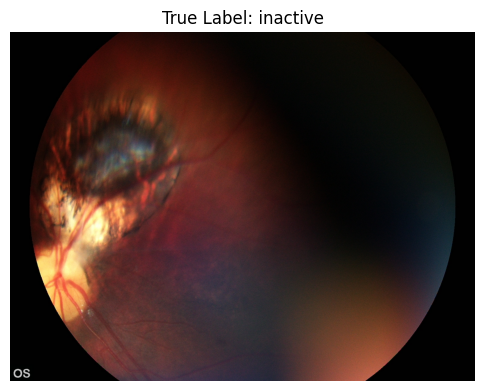


CLASSIFICATION RESULTS
healthy      ███████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 29.12%
active       ██████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 25.94%
inactive     █████████████████░░░░░░░░░░░░░░░░░░░░░░░ 44.95%

✅ Prediction: INACTIVE
   Confidence: 44.95%
   True Label: INACTIVE
   Correct: ✅


In [ ]:
import random
import torch
import torch.nn as nn
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt

# Load the fine-tuned model with classification head
class ClassificationHead(nn.Module):
    def __init__(self, input_dim=512, num_classes=3, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = self.dropout(x)
        return self.fc(x)

class BiomedCLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes=3):
        super().__init__()
        self.clip_model = clip_model

        # Get embedding dimension
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224).to(next(clip_model.parameters()).device)
            image_features = clip_model.encode_image(dummy_input)
            embed_dim = image_features.shape[-1]

        self.classifier = ClassificationHead(embed_dim, num_classes)

    def forward(self, images):
        image_features = self.clip_model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        logits = self.classifier(image_features)
        return logits

# Load test data
import json
test_data = []
with open('prepared_data/test.jsonl', 'r') as f:
    for line in f:
        test_data.append(json.loads(line))

# Load the fine-tuned model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class_names = ['healthy', 'active', 'inactive']

# Load base CLIP model
import open_clip
clip_model, _, preprocess = open_clip.create_model_and_transforms(
    'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
)
clip_model = clip_model.to(device)

# Create classifier and load weights
model = BiomedCLIPClassifier(clip_model, num_classes=3)
checkpoint = torch.load('models/best_model_classifier.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"✓ Model loaded (trained for {checkpoint['epoch']} epochs)")
print(f"  Validation accuracy: {checkpoint['val_acc']:.2f}%")

# Pick random test image
test_item = random.choice(test_data)
image_path = test_item['image']
true_label = test_item['label']

# Display image
img = Image.open(image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title(f"True Label: {true_label}")
plt.show()

# Classify with classification head
image_tensor = preprocess(img).unsqueeze(0).to(device)
with torch.no_grad():
    logits = model(image_tensor)
    probs = torch.softmax(logits, dim=1)[0]

# Display results
print("\n" + "="*50)
print("CLASSIFICATION RESULTS")
print("="*50)
for class_name, prob in zip(class_names, probs):
    bar_length = int(prob * 40)
    bar = "█" * bar_length + "░" * (40 - bar_length)
    print(f"{class_name:12s} {bar} {prob*100:5.2f}%")

predicted = class_names[probs.argmax()]
confidence = probs.max() * 100
print("\n" + "="*50)
print(f"✅ Prediction: {predicted.upper()}")
print(f"   Confidence: {confidence:.2f}%")
print(f"   True Label: {true_label.upper()}")
print(f"   Correct: {'✅' if predicted == true_label else '❌'}")
print("="*50)

## 💾 Step 8: Download Model (Optional)

Download the trained model to use locally.

In [ ]:
from google.colab import files

# Download best model
print("📥 Downloading model...")
files.download('models/best_model.pt')
print("✅ Model downloaded!")
print("\nTo use locally:")
print("1. Load with: model.load_state_dict(torch.load('best_model.pt'))")
print("2. Use the inference code from Step 7")